![caption](images/07Q.png)

## Outline:

#### Nerve segmentation problem
1. We will consider volumes of dimesion 350 x 350 x 1024 depicting nerves at a 3d level. The original data was much larger (2048x2048x2048). We will seek to segment the dark appearance of myelin from the background image.
2. A succesfull segmentation of a nerve will result in a surface imbedded in the volume outlineing the myelin.
3. The segmentation can be performed using MRF's or Deformable models
    * In a MRF apporach we create a 3d graph structure on the whole volume. A suitable prior is chosen, and the model is optimized using s-t graph cuts. A slice-by-slice implementation can also be made. However this assumed independence between the slices, and as we now, that the nerves are alongated, this approach does not seem usefull.
    * Using deformable models each slice of the volume would be segmented on its own. In practice the top layer would first be segmented, and the snake obtained would be used in the initialization of the segmentation of the second layer. If a parametric curve representation is used, then this limits the algorithm to only segmenting a single nerve at a time.

#### MRF segmentation:
1. The classification of each feature vector can be done using knn. With the euclidean distance measure. This method is however not found to be robust.
2. Instead k-means clutering can be performed on the features of the training image. The distribution of labels within each cluster can then be used to assign a probability for a certain label for a feature vector of the test image. This will result in a probability image. This is the method that will be used in the following.

#### Deformable model:
1. A deformable model is initialized on the top image of the volume. 4 snakes are created using a parametric representation to outline 4 seperate nerves.
2. The snakes obtained are used for the initializing the model on the next image in the volume.

#### Key take aways:
1. The MRF 2d computation provides a good segmentation of a testimage, thus motivating further investigation of this model.
2. The 3d computation also provides a visualy appealing segmentation.
3. From the MRF segmentation we can easily compute the myelin density for each frame, as the colored proportion of the image.
4. We can compute the nerve area from the deformable model as the number of pixels inside the snake at a given frame. By also doing an MRF segmentation we can compute the number of coulered voxels inside the snake corresponding to the amount of myelin. The axon are can then be considered as myelin area subtracted from the total are. From this we can compute:
    * Average nerve area
    * The myelin density as a fraction of these numbers.
    * Assuming the the nerves are circular, the radius can be computed from the nerve area.
We can compute the myelin density from the MRF segmentation as the proportion of coloured pixels to the total amount of pixels.
5. The Deformable model only manages to approximate the inside of the nerves. For the calculations above to work it has to approximate the outside.

#### Note:
* Axons: The center part of the nerves.
* Myelin: The dark circular shapes.

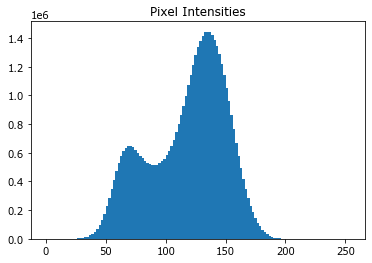

In [1]:
# Helpers
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
from imageio import get_reader
import maxflow
import warnings
import sklearn
warnings.filterwarnings('ignore')

def playMovie(frames):
    %matplotlib tk
    fig, ax = plt.subplots(1,1)
    for frame in frames:
        ax.cla()
        ax.imshow(frame)
        plt.pause(0.01)
    plt.close()
    %matplotlib inline
    return

def segmentationHistogram(img_noise):
    plt.hist(img_noise.flatten(), bins=range(0, 255, 2))
    plt.title('Pixel Intensities')
    plt.show()
    return

# Only import the first 400 images for computational efficiency:
mov = get_reader("nerves_part.tiff")
frames = []
for i, item in enumerate(mov):
    if i < 400:
        frames.append(item)
frames = np.array(frames)

# Movie of the imported image:
# playMovie(frames)

# Pixel Intesities:
segmentationHistogram(frames)

# Inside and outside mu's are set:
mu1 = 60.0
mu2 = 130.0


## First we consider a 2d model:

In [2]:
# 2d Model Fit:
# Neighbourhood hyperparameter
beta=200
f = frames[0]

# Create the graph.
g = maxflow.Graph[int]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(f.shape)

# Create matrix describing neigbourhood structure:
structure=np.array([[0,1,0],
                    [1,0,1],
                    [0,1,0]])

# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, weights=beta, structure=structure, symmetric=True)

source_capacity = (mu1 - f)**2 #relies on first class
sink_capacity = (mu2 - f)**2 #relies on second class

# Add the terminal edges (likelihood weights):
g.add_grid_tedges(nodeids, source_capacity, sink_capacity)

# Find the maximum flow.
print("Maxflow: ", g.maxflow())
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)

# Set values to 0 and 1:
sgm = np.array(list(map(lambda x: list(map(lambda y: 1.0 if y else 0.0, x)), sgm)))

Maxflow:  48290536


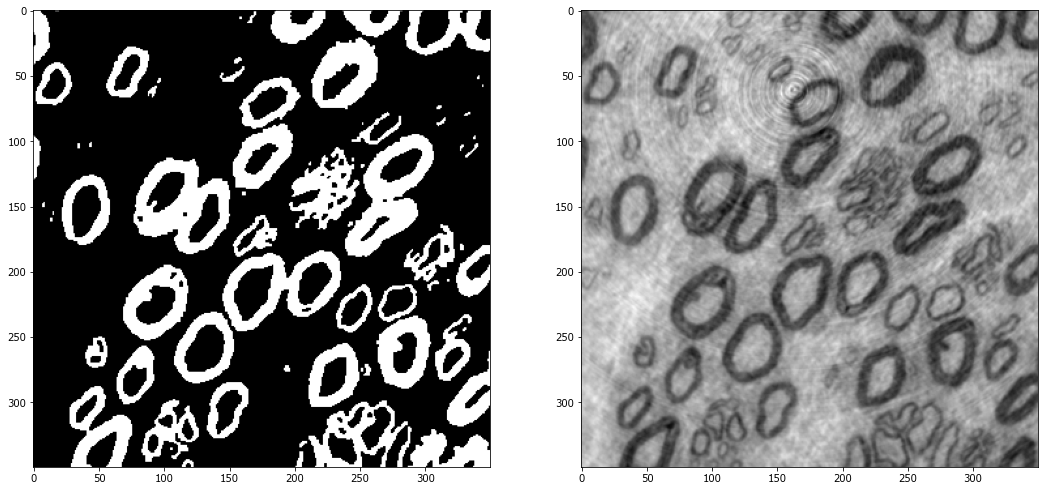

In [3]:
# PLots the segmentation of the first image:
%matplotlib inline
fig3, f3_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(18,12))
f3_axes[1].imshow(f, cmap = "gray")
f3_axes[0].imshow(sgm, cmap = "gray", vmin=0, vmax=1)
fig3.show()

## Now a 3d model is considered:

In [2]:
# We initalize the graph representing the model:
beta = 20
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(frames.shape)
#print(nodeids.shape)

In [3]:
# We define the neighbourhood structure:
top_bot = np.array([[0,0,0],
                    [0,10,0],
                    [0,0,0]])
mid = np.array([[0,1,0],
                [1,0,1],
                [0,1,0]])
structure = np.array([top_bot, mid, top_bot])
print(structure)

[[[ 0  0  0]
  [ 0 10  0]
  [ 0  0  0]]

 [[ 0  1  0]
  [ 1  0  1]
  [ 0  1  0]]

 [[ 0  0  0]
  [ 0 10  0]
  [ 0  0  0]]]


In [4]:
# Add edges to graph
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, weights=beta, structure=structure, symmetric=True)

source_capacity = (mu1 - frames)**2 #relies on first class
sink_capacity = (mu2 - frames)**2 #relies on second class

# Add the terminal edges (likelihood weights):
g.add_grid_tedges(nodeids, source_capacity, sink_capacity)

In [5]:
# Find the maximum flow.
print("Maxflow: ", g.maxflow())
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)

Maxflow:  17989602519.0


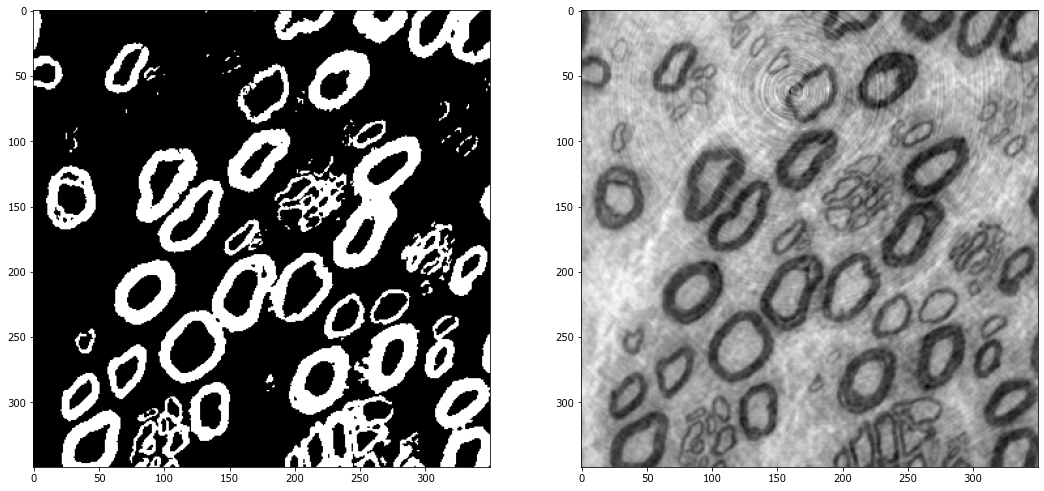

In [6]:
# Plot test output:
fig3, f3_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(18,12))
f3_axes[1].imshow(frames[49], cmap = "gray")
f3_axes[0].imshow(sgm[49], cmap = "gray")
fig3.show()

In [20]:
import imageio
imageio.mimwrite('MRF_movie.mp4', np.concatenate(((255*sgm).astype('uint8'), frames), 2), fps = 10.0)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (700, 350) to (704, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [21]:
# Visualize the segmentation over time:
def playMovie(fr, mov):
    %matplotlib tk
    fig, ax = plt.subplots(1,2)
    for i in range(400):
        ax[1].cla()
        ax[0].cla()
        ax[1].imshow(mov[i])
        ax[0].imshow(fr[i])
        plt.pause(0.1)
    plt.close()
    %matplotlib inline
    return
#playMovie(sgm, frames)

# Deformable models:

In [557]:
# Import image.
import skimage.draw as draw
# Import nerve and process to numpy
mov = get_reader("nerves_part.tiff")
frames = []
for i, item in enumerate(mov):
    if i < 120:
        frames.append(item) # 
frames = np.float32(np.array(frames))/255.

In [558]:
# Helper functions
# Initializes a snake
def fillSnake(x_0, y_0, n, r):
    snake = np.zeros((n, 2))
    angle = 1/(float(n))
    for i, coord in enumerate(snake):
        coord = [x_0 + np.ceil(r*math.cos(2*i*math.pi*angle)), y_0 + np.ceil(r*math.sin(2*i*math.pi*angle))]
        snake[i] = coord
    return(snake)

# Compute mean intensities outside and inside the curve:
def m1m2(frame, snake):
    c_in, c_out=0, 0
    m_in, m_out=0, 0
    x, y = frame.shape
    mask = draw.polygon2mask((x, y), snake)
    for i in range(x):
        for j in range(y):
            if mask[i,j]:
                m_in=((c_in)/(c_in+1))*m_in + 1/(c_in+1)*frame[i,j]
                c_in+=1
            else:
                m_out=((c_out)/(c_out+1))*m_out + 1/(c_out+1)*frame[i,j]
                c_out+=1
    return m_in, m_out, c_in, c_out #returns the average on the inside on the average on the outside of the snake.

# Compute the external force on on image given a snake.
def forceImage_ext(frame, snake, m_in, m_out):
    z = np.array(list(map(lambda x: frame[int(x[0]), int(x[1])], snake)))
    f_ext = (m_in-m_out)*(z-0.5*(m_in+m_out))
    return f_ext

# Compute the normal vectors of the snake:
def snakeNormals(snake):
    N = np.zeros((len(snake), 2))
    diff = snake[1,:]-snake[-1,:]
    N[0,:] = [diff[1], -diff[0]]
    for i in range(len(snake)-2):
        k=i+1
        diff = snake[k+1,:]-snake[k-1]
        N[k,:] = [diff[1], -diff[0]]
    diff = snake[0,:]-snake[-2,:]
    N[-1,:] = [diff[1], -diff[0]]
    return N

# Create snake smoothing matrix. alhpa: elasticity, and beta: rigidity.
def extendedKernelSmothing(alpha, beta, N):
    Alph = np.zeros((N,N))
    Alph[1:, :-1] = Alph[1:, :-1] + np.identity(N-1)
    Alph[:-1, 1:] = Alph[:-1, 1:] + np.identity(N-1)
    Alph = Alph + (-2)*np.identity(N)
    Alph[0,N-1] = 1
    Alph[N-1,0] = 1
    Bet = np.zeros((N,N)) + (-6)*np.identity(N)
    Bet[2:,:-2] = Bet[2:,:-2] + (-1)*np.identity(N-2)
    Bet[:-2,2:] = Bet[:-2,2:] + (-1)*np.identity(N-2)
    Bet[1:,:-1] = Bet[1:,:-1] + 4*np.identity(N-1)
    Bet[:-1,1:] = Bet[:-1,1:] + 4*np.identity(N-1)
    Bet[0,N-2] = -1
    Bet[1,N-1] = -1
    Bet[N-2,0] = -1
    Bet[N-1,1] = -1
    Bet[N-1, 0] = 4
    Bet[0, N-1] = 4
    #print(Alph)
    #print(Bet)
    return(alpha*Alph + beta*Bet)

def updateSnake(snake, frame, tau, HARDCODE=0):
    # Mean intensities:
    if HARDCODE==1:
        #m_in, m_out = 130.0/255.0, 60.0/255.0 # set mean_in and mean_out from histogram
        m_in, m_out = 60.0/255.0, 120.0/255.0
    else:
        m_in, m_out, c_in, c_out = m1m2(frame, snake) # get averages inside/outside
    
    # Compute external forces:
    z = forceImage_ext(frame, snake, m_in, m_out) # get values of force on curve
    
    # Compute the normal vectors of the snake:
    N = snakeNormals(snake)
    
    # Compute the displacement:
    displacement = np.array([N[i]*z[i] for i in range(n)])
    
    # Update and smooth snake:
    snake_smooth = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake + tau*displacement)
    return snake_smooth

In [559]:
# parameters
tau = 10 # displacement parameter
alpha = 0.01 # elasticity (length minimizing)
beta = 1 # rigidity (curvature minimizing)
n=20 # snake lenght
x_0 = [215, 208, 256, 230] # snake center x
y_0 = [170, 218, 134, 90] # snake center y
r = np.array([10, 10, 12, 12])*2
tau= [10, 5, 5, 10]
# Creates smoothing matrix:
B_int = extendedKernelSmothing(alpha, beta, n)

In [560]:
# Test snake update:
# We create a snake:
snake = fillSnake(x_0[0], y_0[0], n, r[0])

# Mean intensities are set from the histogram:
_, _, c_in, c_out = m1m2(frames[0], snake)
m_in, m_out = 130.0/255.0, 60.0/255.0

# Compute external forces:
z = forceImage_ext(frames[0], snake, m_in, m_out)

# Compute the normal vectors of the snake:
N = snakeNormals(snake)

# Compute the displacement:
displacement = np.array([N[i]*z[i] for i in range(n)])

# Compute the updated snake:
snake_new = snake + 10*displacement

# Smooth snake:
snake_new = np.matmul(np.linalg.inv(np.identity(n)-B_int), snake_new)

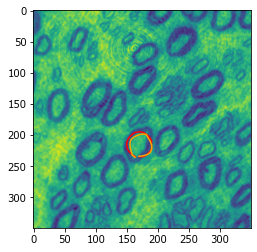

In [561]:
# Update plot
plt.plot(snake[:,1], snake[:,0], color = 'red')
plt.plot(snake_new[:,1], snake_new[:,0]+displacement[:,0], color = 'orange')
plt.imshow(frames[0])
plt.show()

## Initialize snake::

In [562]:
# We create the snakes to be used:
snakes = np.array([fillSnake(x_0[i], y_0[i], n, r[i]) for i in range(4)])

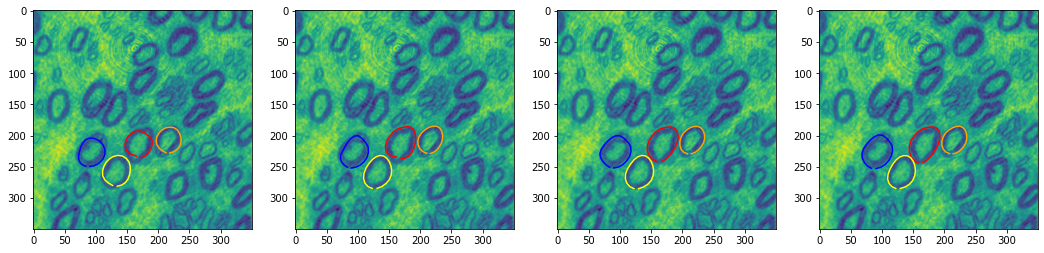

In [563]:
# Intitialize snakes using the first frame:
snakes_new = snakes
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(18, 12)
#tau=10
p = 10

s_test = []

for i in range(2*16):
    for j, snake in enumerate(snakes_new):
        snakes_new[j] = updateSnake(snakes_new[j], frames[0], tau=tau[j], HARDCODE=1)
    s_test.append(snakes_new)
    if i%p==0:
        ax[int(i/p)].plot(snakes_new[0][:,1], snakes_new[0][:,0], color = 'red')
        ax[int(i/p)].plot(snakes_new[1][:,1], snakes_new[1][:,0], color = 'orange')
        ax[int(i/p)].plot(snakes_new[2][:,1], snakes_new[2][:,0], color = 'yellow')
        ax[int(i/p)].plot(snakes_new[3][:,1], snakes_new[3][:,0], color = 'blue')
        ax[int(i/p)].imshow(frames[0])

## Compute the snake evolution:

In [564]:
# Create list of snakes
snake_film = np.zeros((len(frames), len(snakes_new), n, 2))
snake_film[0] = snakes_new

In [565]:
# Update snakes iteratively:
tau=[3, 7, 3, 3] 
for k, frame in enumerate(frames[1:111]): #81
    for i in range(10):
        for j in range(len(snakes_new)):
            if i==0:
                snake_film[k+1, j] = updateSnake(snake_film[k, j], frames[k+1], tau[j], HARDCODE=1)
            else:
                snake_film[k+1, j] = updateSnake(snake_film[k+1, j], frames[k+1], tau[j], HARDCODE=1)

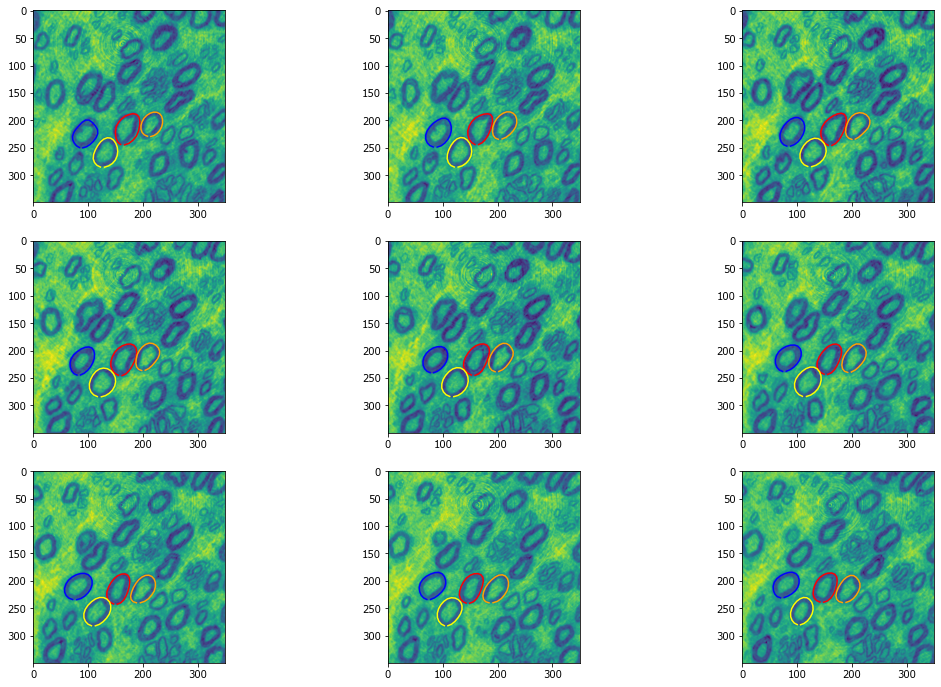

In [566]:
# Plot resulting snakes for every 10'th picture
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(18, 12)
for i in range(9):
    ax[int(i/3), i%3].plot(snake_film[12*i][0][:,1], snake_film[12*i][0][:,0], color = 'red')
    ax[int(i/3), i%3].plot(snake_film[12*i][1][:,1], snake_film[12*i][1][:,0], color = 'orange')
    ax[int(i/3), i%3].plot(snake_film[12*i][2][:,1], snake_film[12*i][2][:,0], color = 'yellow')
    ax[int(i/3), i%3].plot(snake_film[12*i][3][:,1], snake_film[12*i][3][:,0], color = 'blue')
    ax[int(i/3), i%3].imshow(frames[12*i])